In [1]:
import torch
from torch import nn, Tensor
from torch.distributions import Uniform
from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np

from smcdet.prior import M71Prior
from smcdet.images import M71ImageModel
from smcdet.distributions import TruncatedPareto

import pickle

Define prior and image model:

In [2]:
with open('../experiments/m71/data/params.pkl', 'rb') as f:
    params = pickle.load(f)

In [3]:
image_dim = 16
pad = 2

loc_prior = Uniform(
    (0 - pad) * torch.ones(2),
    torch.tensor((image_dim + pad, image_dim + pad))
)
flux_prior = TruncatedPareto(
    alpha = params["flux_alpha"],
    lower = params["flux_detection_threshold"],
    upper = params["flux_upper"]
)

In [4]:
imagemodel = M71ImageModel(
    image_height = image_dim,
    image_width = image_dim,
    background = params["background"],
    adu_per_nmgy = params["adu_per_nmgy"],
    psf_params = params["psf_params"],
    noise_additive = params["noise_additive"],
    noise_multiplicative = params["noise_multiplicative"]
)

Sample 1000 catalogs and images. Each catalog has one star parametrized by a flux (in nmgy) and a 2D location:

In [5]:
num_images = 1000

locs = loc_prior.sample([num_images])
logfluxes = flux_prior.sample([num_images,1]).log()

catalogs = torch.cat((locs, logfluxes), dim=-1)

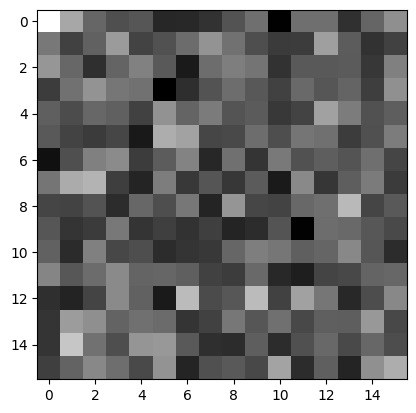

In [6]:
images = imagemodel.sample(rearrange(locs, "n t -> 1 1 n 1 t"),
                           rearrange(logfluxes.exp(), "n 1 -> 1 1 n 1"))
images = rearrange(images, "1 1 dimH dimW n -> n 1 dimH dimW")

idx = torch.randint(0,num_images,[])
_ = plt.imshow(images[idx].squeeze(), cmap = 'gray')

Define flow:

In [7]:
class Flow(nn.Module):
    def __init__(self, catalog_dim: int, h: int):
        super().__init__()

        self.image_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.SiLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, h)
        )

        self.velocity_net = nn.Sequential(
            nn.Linear(catalog_dim + h + 1, h),
            nn.SiLU(),
            nn.Linear(h, h),
            nn.SiLU(),
            nn.Linear(h, h),
            nn.SiLU(),
            nn.Linear(h, catalog_dim)
        )
    
    def forward(self, z: Tensor, x: Tensor, t: Tensor) -> Tensor:
        x_encoded = self.image_encoder(x)
        return self.velocity_net(torch.cat((z, x_encoded, t), dim=-1))

    def step(self, z: Tensor, x: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(z.shape[0], 1)
        x_mid = z + self(z, x, t_start) * (t_end - t_start) / 2
        v_mid = self(x_mid, x, t_start + (t_end - t_start) / 2)

        return z + (t_end - t_start) * v_mid

Train the flow:

In [8]:
flow = Flow(catalog_dim=catalogs.shape[-1], h = 64)
optimizer = torch.optim.Adam(flow.parameters(), lr = 1e-3)
loss = nn.MSELoss()

In [9]:
batch_size = 32

for step in range(10000):
    indices = torch.randint(low = 0, high = images.shape[0], size = [batch_size])
    x = images[indices]
    z1 = catalogs[indices]

    z0_locs = loc_prior.sample([batch_size])
    z0_logfluxes = flux_prior.sample([batch_size, 1]).log()
    z0 = torch.cat((z0_locs, z0_logfluxes), dim=-1)

    t = torch.rand(len(z1), 1)

    zt = (1 - t) * z0 + t * z1

    dzt = z1 - z0

    optimizer.zero_grad()

    pred = flow(zt, x, t)

    l = loss(pred, dzt)
    l.backward()

    if step % 100 == 0:
        print(step)
        print(l)
    
    optimizer.step()

0
tensor(46.3203, grad_fn=<MseLossBackward0>)
100
tensor(40.5907, grad_fn=<MseLossBackward0>)
200
tensor(51.8796, grad_fn=<MseLossBackward0>)
300
tensor(46.9577, grad_fn=<MseLossBackward0>)
400
tensor(40.1067, grad_fn=<MseLossBackward0>)
500
tensor(36.1224, grad_fn=<MseLossBackward0>)
600
tensor(47.6815, grad_fn=<MseLossBackward0>)
700
tensor(37.4254, grad_fn=<MseLossBackward0>)
800
tensor(42.6621, grad_fn=<MseLossBackward0>)
900
tensor(28.1026, grad_fn=<MseLossBackward0>)
1000
tensor(32.0554, grad_fn=<MseLossBackward0>)
1100
tensor(35.9818, grad_fn=<MseLossBackward0>)
1200
tensor(22.8366, grad_fn=<MseLossBackward0>)
1300
tensor(22.4128, grad_fn=<MseLossBackward0>)
1400
tensor(14.7556, grad_fn=<MseLossBackward0>)
1500
tensor(19.3580, grad_fn=<MseLossBackward0>)
1600
tensor(13.5190, grad_fn=<MseLossBackward0>)
1700
tensor(11.4121, grad_fn=<MseLossBackward0>)
1800
tensor(12.8473, grad_fn=<MseLossBackward0>)
1900
tensor(21.4038, grad_fn=<MseLossBackward0>)
2000
tensor(13.3813, grad_fn=<Ms

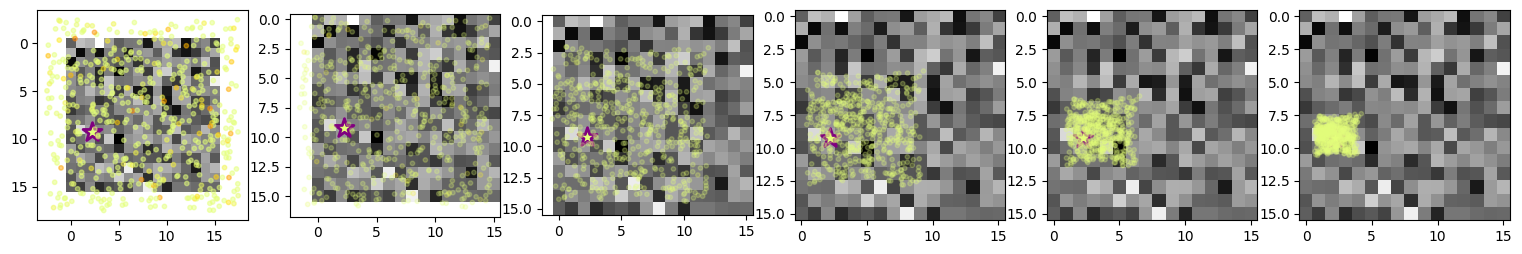

In [10]:
num_samples = 500

z_locs = loc_prior.sample([num_samples])
z_logfluxes = flux_prior.sample([num_samples,1]).log()
z = torch.cat((z_locs, z_logfluxes), dim=-1)

image_index = torch.randint(0, images.shape[0], size = [])
x = images[image_index].unsqueeze(0).expand(num_samples, 1, image_dim, image_dim)

n_steps = 5
time_steps = torch.linspace(0.0, 1.0, n_steps + 1)

fig, ax = plt.subplots(1, n_steps + 1, figsize = (4*n_steps - 1, 3))
_ = ax[0].imshow(images[image_index].squeeze(), cmap = 'gray')
_ = ax[0].scatter(locs[image_index][1] - 0.5, locs[image_index][0] - 0.5,
                  c = logfluxes[image_index].exp(), cmap = 'Wistia',
                  marker = '*', edgecolors = 'purple', linewidth = 2, s = 200)
_ = ax[0].scatter(z_locs[:,1] - 0.5, z_locs[:,0] - 0.5,
                  c = z_logfluxes.exp(), cmap = 'Wistia', s = 10, alpha = 0.5)

for t in range(n_steps):
    z = flow.step(z, x, time_steps[t], time_steps[t+1])

    sampled_locs = z.detach()[:,:2]
    sampled_fluxes = z.detach()[:,2].exp()

    _ = ax[t+1].imshow(images[image_index].squeeze(), cmap = 'gray')
    _ = ax[t+1].scatter(locs[image_index][1] - 0.5, locs[image_index][0] - 0.5,
                        c = logfluxes[image_index].exp(), cmap = 'Wistia',
                        marker = '*', edgecolors = 'purple', linewidth = 2, s = 200)
    _ = ax[t+1].scatter(sampled_locs[:,1] - 0.5, sampled_locs[:,0] - 0.5,
                        c = sampled_fluxes, vmin = z_logfluxes.exp().min(), vmax = z_logfluxes.exp().max(),
                        cmap = 'Wistia', s = 10, alpha = 0.25)